<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing-Tutorial/blob/main/SUnCNNCollab_DC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/BehnoodRasti/SUnCNN.git

Cloning into 'SUnCNN'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 97 (delta 42), reused 92 (delta 40), pack-reused 0
Unpacking objects: 100% (97/97), done.


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from SUnCNN.models import *

import torch
import torch.optim

from skimage.metrics  import peak_signal_noise_ratio as compare_psnr
from skimage.metrics  import mean_squared_error as compare_mse

from SUnCNN.utils.denoising_utils import *

from skimage._shared import *
from skimage.util import *
from skimage.metrics.simple_metrics import _as_floats
from skimage.metrics.simple_metrics import mean_squared_error


from SUnCNN.UtilityMine import *
from SUnCNN.utils.sr_utils import tv_loss
from numpy import linalg as LA

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = False
import scipy.io
#%%
fname2  = "SUnCNN/Data/DC1/Y_clean.mat"
mat2 = scipy.io.loadmat(fname2)
img_np_gt = mat2["Y_clean"]
img_np_gt = img_np_gt.transpose(2,0,1)
[p1, nr1, nc1] = img_np_gt.shape
#%%
fname3  = "SUnCNN/Data/DC1/XT.mat"
mat3 = scipy.io.loadmat(fname3)
A_true_np = mat3["XT"]

#%%
fname4  = "SUnCNN/Data/DC1/EE.mat"
mat4 = scipy.io.loadmat(fname4)
EE = mat4["EE"]
#%%
LibS=EE.shape[1]
#%%
npar=np.zeros((1,3))
npar[0,0]=13.3
npar[0,1]=41.4
npar[0,2]=130.8
#npar[0,3]=367
tol1=npar.shape[1]
tol2=1
save_result=False
import time
from tqdm import tqdm
rmax=5

  0%|          | 0/1 [00:00<?, ?it/s]

20.179051104998717
CAE_AbEst(
  (conv1): Sequential(
    (0): Sequential(
      (1): Concat(
        (0): Sequential(
          (1): Sequential(
            (0): ReflectionPad2d((0, 0, 0, 0))
            (1): Conv2d(224, 4, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (1): Sequential(
          (1): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(224, 256, kernel_size=(3, 3), stride=(2, 2))
          )
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.1, inplace=True)
          (4): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
          (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 00000    Loss 0.106742   MAE_LR: 0.816361 MAE_LR_avg: 0.816361  SRE: 0.019319 SRE_avg: 0.019319


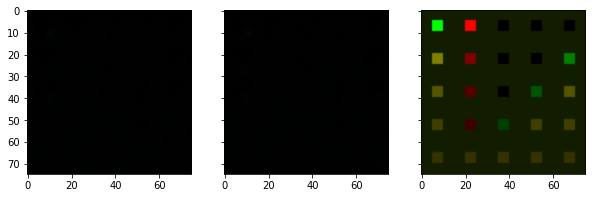

Iteration 00001    Loss 0.096047   MAE_LR: 0.813316 MAE_LR_avg: 0.816305  SRE: -0.098406 SRE_avg: 0.019440
Iteration 00002    Loss 0.086226   MAE_LR: 0.809151 MAE_LR_avg: 0.816165  SRE: -0.160026 SRE_avg: 0.019973
Iteration 00003    Loss 0.075552   MAE_LR: 0.801222 MAE_LR_avg: 0.815919  SRE: -0.162978 SRE_avg: 0.021309
Iteration 00004    Loss 0.065281   MAE_LR: 0.796724 MAE_LR_avg: 0.815608  SRE: -0.197072 SRE_avg: 0.023094
Iteration 00005    Loss 0.056138   MAE_LR: 0.794210 MAE_LR_avg: 0.815173  SRE: -0.242689 SRE_avg: 0.025345
Iteration 00006    Loss 0.047543   MAE_LR: 0.790646 MAE_LR_avg: 0.814669  SRE: -0.266394 SRE_avg: 0.027816
Iteration 00007    Loss 0.039842   MAE_LR: 0.786788 MAE_LR_avg: 0.814150  SRE: -0.261642 SRE_avg: 0.030247
Iteration 00008    Loss 0.033321   MAE_LR: 0.783602 MAE_LR_avg: 0.813593  SRE: -0.278759 SRE_avg: 0.032580
Iteration 00009    Loss 0.028017   MAE_LR: 0.781209 MAE_LR_avg: 0.812922  SRE: -0.332495 SRE_avg: 0.035115
Iteration 00010    Loss 0.024086   MA

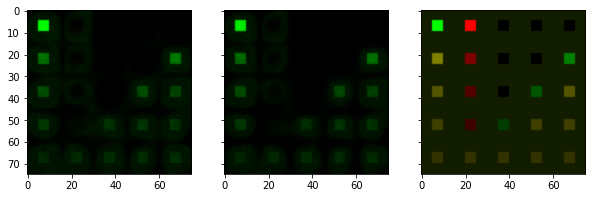

Iteration 00501    Loss 0.000134   MAE_LR: 0.324305 MAE_LR_avg: 0.348990  SRE: 2.638457 SRE_avg: 2.603901
Iteration 00502    Loss 0.000133   MAE_LR: 0.324236 MAE_LR_avg: 0.348726  SRE: 2.638421 SRE_avg: 2.604605
Iteration 00503    Loss 0.000133   MAE_LR: 0.324101 MAE_LR_avg: 0.348464  SRE: 2.638055 SRE_avg: 2.605296
Iteration 00504    Loss 0.000133   MAE_LR: 0.323945 MAE_LR_avg: 0.348203  SRE: 2.638549 SRE_avg: 2.605979
Iteration 00505    Loss 0.000133   MAE_LR: 0.323649 MAE_LR_avg: 0.347942  SRE: 2.639794 SRE_avg: 2.606668
Iteration 00506    Loss 0.000133   MAE_LR: 0.323393 MAE_LR_avg: 0.347680  SRE: 2.640205 SRE_avg: 2.607360
Iteration 00507    Loss 0.000133   MAE_LR: 0.323273 MAE_LR_avg: 0.347421  SRE: 2.640422 SRE_avg: 2.608042
Iteration 00508    Loss 0.000133   MAE_LR: 0.323041 MAE_LR_avg: 0.347161  SRE: 2.641487 SRE_avg: 2.608722
Iteration 00509    Loss 0.000133   MAE_LR: 0.322822 MAE_LR_avg: 0.346902  SRE: 2.642100 SRE_avg: 2.609405
Iteration 00510    Loss 0.000132   MAE_LR: 0.3

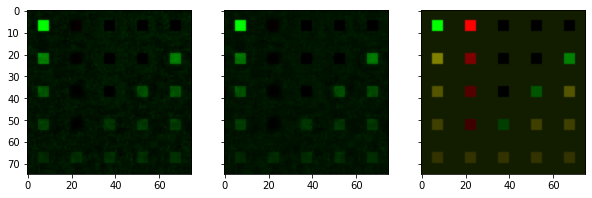

Iteration 01001    Loss 0.000095   MAE_LR: 0.263975 MAE_LR_avg: 0.269852  SRE: 2.915531 SRE_avg: 2.877547
Iteration 01002    Loss 0.000096   MAE_LR: 0.265361 MAE_LR_avg: 0.269791  SRE: 2.882970 SRE_avg: 2.877871
Iteration 01003    Loss 0.000098   MAE_LR: 0.263796 MAE_LR_avg: 0.269714  SRE: 2.907262 SRE_avg: 2.878443
Iteration 01004    Loss 0.000098   MAE_LR: 0.264987 MAE_LR_avg: 0.269650  SRE: 2.891697 SRE_avg: 2.878849
Iteration 01005    Loss 0.000097   MAE_LR: 0.264332 MAE_LR_avg: 0.269582  SRE: 2.895512 SRE_avg: 2.879260
Iteration 01006    Loss 0.000096   MAE_LR: 0.263933 MAE_LR_avg: 0.269506  SRE: 2.902619 SRE_avg: 2.879805
Iteration 01007    Loss 0.000096   MAE_LR: 0.265344 MAE_LR_avg: 0.269447  SRE: 2.862506 SRE_avg: 2.879998
Iteration 01008    Loss 0.000094   MAE_LR: 0.263759 MAE_LR_avg: 0.269372  SRE: 2.915798 SRE_avg: 2.880630
Iteration 01009    Loss 0.000096   MAE_LR: 0.262218 MAE_LR_avg: 0.269282  SRE: 2.937125 SRE_avg: 2.881496
Iteration 01010    Loss 0.000095   MAE_LR: 0.2

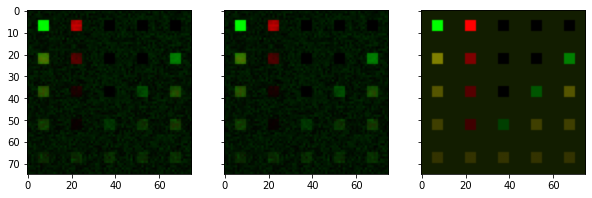

Iteration 01501    Loss 0.000070   MAE_LR: 0.239033 MAE_LR_avg: 0.243057  SRE: 3.252802 SRE_avg: 3.223401
Iteration 01502    Loss 0.000070   MAE_LR: 0.239135 MAE_LR_avg: 0.243016  SRE: 3.252822 SRE_avg: 3.223758
Iteration 01503    Loss 0.000070   MAE_LR: 0.239228 MAE_LR_avg: 0.242976  SRE: 3.252847 SRE_avg: 3.224107
Iteration 01504    Loss 0.000070   MAE_LR: 0.239183 MAE_LR_avg: 0.242936  SRE: 3.249036 SRE_avg: 3.224412
Iteration 01505    Loss 0.000070   MAE_LR: 0.239077 MAE_LR_avg: 0.242895  SRE: 3.251560 SRE_avg: 3.224741
Iteration 01506    Loss 0.000070   MAE_LR: 0.239013 MAE_LR_avg: 0.242854  SRE: 3.252597 SRE_avg: 3.225075
Iteration 01507    Loss 0.000070   MAE_LR: 0.238675 MAE_LR_avg: 0.242811  SRE: 3.258482 SRE_avg: 3.225467
Iteration 01508    Loss 0.000070   MAE_LR: 0.238853 MAE_LR_avg: 0.242769  SRE: 3.254787 SRE_avg: 3.225816
Iteration 01509    Loss 0.000070   MAE_LR: 0.238751 MAE_LR_avg: 0.242727  SRE: 3.254002 SRE_avg: 3.226155
Iteration 01510    Loss 0.000070   MAE_LR: 0.2

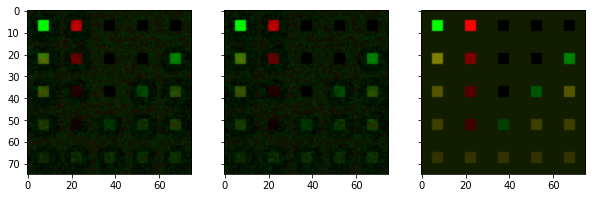

Iteration 02001    Loss 0.000065   MAE_LR: 0.204906 MAE_LR_avg: 0.209330  SRE: 3.469893 SRE_avg: 3.444267
Iteration 02002    Loss 0.000065   MAE_LR: 0.205093 MAE_LR_avg: 0.209283  SRE: 3.446838 SRE_avg: 3.444378
Iteration 02003    Loss 0.000065   MAE_LR: 0.204875 MAE_LR_avg: 0.209235  SRE: 3.461606 SRE_avg: 3.444640
Iteration 02004    Loss 0.000065   MAE_LR: 0.203456 MAE_LR_avg: 0.209173  SRE: 3.499289 SRE_avg: 3.445257
Iteration 02005    Loss 0.000065   MAE_LR: 0.202746 MAE_LR_avg: 0.209105  SRE: 3.509372 SRE_avg: 3.445964
Iteration 02006    Loss 0.000065   MAE_LR: 0.203779 MAE_LR_avg: 0.209047  SRE: 3.486996 SRE_avg: 3.446436
Iteration 02007    Loss 0.000065   MAE_LR: 0.204429 MAE_LR_avg: 0.208997  SRE: 3.469150 SRE_avg: 3.446721
Iteration 02008    Loss 0.000064   MAE_LR: 0.203863 MAE_LR_avg: 0.208943  SRE: 3.475731 SRE_avg: 3.447060
Iteration 02009    Loss 0.000064   MAE_LR: 0.203723 MAE_LR_avg: 0.208888  SRE: 3.487909 SRE_avg: 3.447520
Iteration 02010    Loss 0.000064   MAE_LR: 0.2

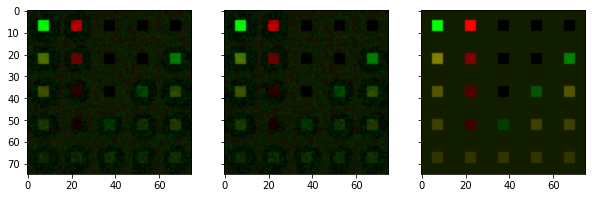

Iteration 02501    Loss 0.000062   MAE_LR: 0.192190 MAE_LR_avg: 0.194104  SRE: 3.610856 SRE_avg: 3.590316
Iteration 02502    Loss 0.000062   MAE_LR: 0.192973 MAE_LR_avg: 0.194092  SRE: 3.604431 SRE_avg: 3.590483
Iteration 02503    Loss 0.000062   MAE_LR: 0.192038 MAE_LR_avg: 0.194070  SRE: 3.614991 SRE_avg: 3.590754
Iteration 02504    Loss 0.000062   MAE_LR: 0.192807 MAE_LR_avg: 0.194056  SRE: 3.607197 SRE_avg: 3.590949
Iteration 02505    Loss 0.000062   MAE_LR: 0.192244 MAE_LR_avg: 0.194036  SRE: 3.606871 SRE_avg: 3.591141
Iteration 02506    Loss 0.000062   MAE_LR: 0.192471 MAE_LR_avg: 0.194019  SRE: 3.616676 SRE_avg: 3.591427
Iteration 02507    Loss 0.000062   MAE_LR: 0.192363 MAE_LR_avg: 0.194001  SRE: 3.607171 SRE_avg: 3.591621
Iteration 02508    Loss 0.000062   MAE_LR: 0.192314 MAE_LR_avg: 0.193982  SRE: 3.609791 SRE_avg: 3.591839
Iteration 02509    Loss 0.000063   MAE_LR: 0.192625 MAE_LR_avg: 0.193965  SRE: 3.613787 SRE_avg: 3.592103
Iteration 02510    Loss 0.000064   MAE_LR: 0.1

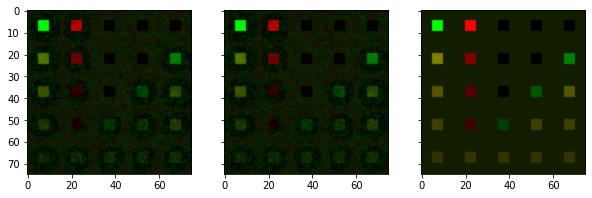

Iteration 03001    Loss 0.000059   MAE_LR: 0.184498 MAE_LR_avg: 0.186177  SRE: 3.777983 SRE_avg: 3.733655
Iteration 03002    Loss 0.000059   MAE_LR: 0.185011 MAE_LR_avg: 0.186165  SRE: 3.756146 SRE_avg: 3.733906
Iteration 03003    Loss 0.000059   MAE_LR: 0.185121 MAE_LR_avg: 0.186154  SRE: 3.751015 SRE_avg: 3.734106
Iteration 03004    Loss 0.000059   MAE_LR: 0.184688 MAE_LR_avg: 0.186139  SRE: 3.770680 SRE_avg: 3.734497
Iteration 03005    Loss 0.000059   MAE_LR: 0.184620 MAE_LR_avg: 0.186123  SRE: 3.772818 SRE_avg: 3.734904
Iteration 03006    Loss 0.000059   MAE_LR: 0.184923 MAE_LR_avg: 0.186111  SRE: 3.757605 SRE_avg: 3.735159
Iteration 03007    Loss 0.000059   MAE_LR: 0.185213 MAE_LR_avg: 0.186101  SRE: 3.755069 SRE_avg: 3.735386
Iteration 03008    Loss 0.000059   MAE_LR: 0.184790 MAE_LR_avg: 0.186087  SRE: 3.766317 SRE_avg: 3.735721
Iteration 03009    Loss 0.000059   MAE_LR: 0.184843 MAE_LR_avg: 0.186074  SRE: 3.765902 SRE_avg: 3.736049
Iteration 03010    Loss 0.000059   MAE_LR: 0.1

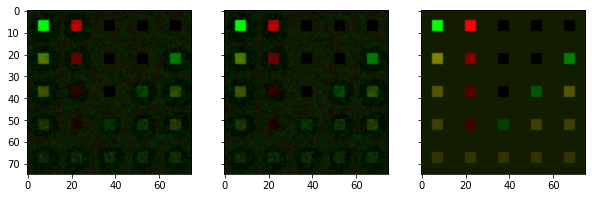

Iteration 03501    Loss 0.000058   MAE_LR: 0.177178 MAE_LR_avg: 0.178784  SRE: 3.969347 SRE_avg: 3.928862
Iteration 03502    Loss 0.000058   MAE_LR: 0.177445 MAE_LR_avg: 0.178769  SRE: 3.963565 SRE_avg: 3.929267
Iteration 03503    Loss 0.000058   MAE_LR: 0.177470 MAE_LR_avg: 0.178754  SRE: 3.957736 SRE_avg: 3.929614
Iteration 03504    Loss 0.000058   MAE_LR: 0.177002 MAE_LR_avg: 0.178735  SRE: 3.975693 SRE_avg: 3.930133
Iteration 03505    Loss 0.000058   MAE_LR: 0.177006 MAE_LR_avg: 0.178716  SRE: 3.992491 SRE_avg: 3.930809
Iteration 03506    Loss 0.000058   MAE_LR: 0.176962 MAE_LR_avg: 0.178697  SRE: 3.993702 SRE_avg: 3.931493
Iteration 03507    Loss 0.000058   MAE_LR: 0.177651 MAE_LR_avg: 0.178685  SRE: 3.963738 SRE_avg: 3.931868
Iteration 03508    Loss 0.000058   MAE_LR: 0.178791 MAE_LR_avg: 0.178684  SRE: 3.932314 SRE_avg: 3.931936
Iteration 03509    Loss 0.000058   MAE_LR: 0.178210 MAE_LR_avg: 0.178678  SRE: 3.948853 SRE_avg: 3.932158
Iteration 03510    Loss 0.000058   MAE_LR: 0.1

Iteration 03996    Loss 0.000055   MAE_LR: 0.168060 MAE_LR_avg: 0.170337  SRE: 4.350550 SRE_avg: 4.244454
Iteration 03997    Loss 0.000055   MAE_LR: 0.167548 MAE_LR_avg: 0.170307  SRE: 4.354073 SRE_avg: 4.245671
Iteration 03998    Loss 0.000054   MAE_LR: 0.167274 MAE_LR_avg: 0.170274  SRE: 4.359863 SRE_avg: 4.246934
Iteration 03999    Loss 0.000054   MAE_LR: 0.167296 MAE_LR_avg: 0.170242  SRE: 4.365903 SRE_avg: 4.248242


100%|██████████| 1/1 [04:31<00:00, 271.45s/it]


In [3]:
for fi in tqdm(range(1)):
    for fj in tqdm(range(tol2)):
            #%%
        img_np_gt=np.clip(img_np_gt, 0, 1)
        img_noisy_np = add_noise(img_np_gt, 1/npar[0,fi])#11.55 20 dB, 36.7 30 dB, 116.5 40 dB
        print(compare_snr(img_np_gt, img_noisy_np))
        img_resh=np.reshape(img_noisy_np,(p1,nr1*nc1))
        V, SS, U = scipy.linalg.svd(img_resh, full_matrices=False)
        PC=np.diag(SS)@U
        img_resh_DN=V[:,:rmax]@PC[:rmax,:]
        img_noisy_np=np.reshape(np.clip(img_resh_DN, 0, 1),(p1,nr1,nc1))
        INPUT = 'noise' # 'meshgrid'
        pad = 'reflection'
        need_bias=True
        OPT_OVER = 'net' # 'net,input'
        
        # 
        reg_noise_std = 0.0
        LR1 = 0.001
        
        OPTIMIZER1='adam'# 'RMSprop'#'adam' # 'LBFGS'
        show_every = 500
        exp_weight=0.99
        if fi==0:
            num_iter1 = 4000
        elif fi==1:
            num_iter1 = 8000
        elif fi==2:
            num_iter1 = 12000
        input_depth =img_noisy_np.shape[0]
        class CAE_AbEst(nn.Module):
            def __init__(self):
                super(CAE_AbEst, self).__init__()
                self.conv1 = nn.Sequential(
                    UnmixArch(
                            input_depth, EE.shape[1],
                            # num_channels_down = [8, 16, 32, 64, 128], 
                            # num_channels_up   = [8, 16, 32, 64, 128],
                            # num_channels_skip = [4, 4, 4, 4, 4], 
                            num_channels_down = [ 256],
                            num_channels_up =   [ 256],
                            num_channels_skip =    [ 4],  
                            filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
                            upsample_mode='bilinear', # downsample_mode='avg',
                            need1x1_up=True,
                            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
                )
        
            def forward(self, x):
                x = self.conv1(x)
                return x

        net1 = CAE_AbEst()
        net1.cuda()
        print(net1)

        # Compute number of parameters
        s  = sum([np.prod(list(p11.size())) for p11 in net1.parameters()]); 
        print ('Number of params: %d' % s)
        
        # Loss
        mse = torch.nn.MSELoss().type(dtype)
        img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
        # if fk==0:
        net_input1 = get_noise(input_depth, INPUT,
          (img_noisy_np.shape[1], img_noisy_np.shape[2])).type(dtype).detach()
        net_input1 = img_noisy_torch 
        E_torch = np_to_torch(EE).type(dtype)
        #%%
        net_input_saved = net_input1.detach().clone()
        noise = net_input1.detach().clone()
        out_avg = None
        out_HR_avg= None
        last_net = None
        RMSE_LR_last = 0
        loss=np.zeros((num_iter1,1))
        AE=np.zeros((num_iter1,1))
        i = 0
        def closure1():
            
            global i, RMSE_LR, RMSE_LR_ave, RMSE_HR, out_LR_np, out_avg_np, out_LR\
                , out_avg,out_HR_np, out_HR_avg, out_HR_avg_np, RMSE_LR_last, last_net\
                    , net_input,RMSE_LR_avg,RMSE_HR_avg,RE_HR_avg, RE_HR, Eest,loss,AE\
                       , MAE_LR,MAE_LR_avg,MAE_HR,MAE_HR_avg
            
            if reg_noise_std > 0:
                net_input = net_input_saved + (noise.normal_() * reg_noise_std)
            
            out_LR = net1(net_input1)
            out_HR=torch.mm(E_torch.view(p1,LibS),out_LR.view(LibS,nr1*nc1))
            # Smoothing
            if out_avg is None:
                out_avg = out_LR.detach()
                out_HR_avg = out_HR.detach()
            else:
                out_avg = out_avg * exp_weight + out_LR.detach() * (1 - exp_weight)
                out_HR_avg = out_HR_avg * exp_weight + out_HR.detach() * (1 - exp_weight)

        #%%
            out_HR=out_HR.view((1,p1,nr1,nc1))
            total_loss = mse(img_noisy_torch, out_HR)
            total_loss.backward()
            if True:
             out_LR_np = out_LR.detach().cpu().squeeze().numpy()
             out_avg_np = out_avg.detach().cpu().squeeze().numpy()
             SRE=10*np.log10(LA.norm(A_true_np.astype(np.float32).reshape((EE.shape[1],nr1*nc1)),'fro')/LA.norm((A_true_np.astype(np.float32)- np.clip(out_LR_np, 0, 1)).reshape((EE.shape[1],nr1*nc1)),'fro'))
             SRE_avg=10*np.log10(LA.norm(A_true_np.astype(np.float32).reshape((EE.shape[1],nr1*nc1)),'fro')/LA.norm((A_true_np.astype(np.float32)- np.clip(out_avg_np, 0, 1)).reshape((EE.shape[1],nr1*nc1)),'fro'))
             MAE_LR= 100*np.mean(abs(A_true_np.astype(np.float32)- np.clip(out_LR_np, 0, 1)))
             MAE_LR_avg= 100*np.mean(abs(A_true_np.astype(np.float32)- np.clip(out_avg_np, 0, 1)))
             print ('Iteration %05d    Loss %f   MAE_LR: %f MAE_LR_avg: %f  SRE: %f SRE_avg: %f' % (i, total_loss.item(), MAE_LR, MAE_LR_avg, SRE, SRE_avg))

            if  PLOT and i % show_every == 0:
                out_LR_np = torch_to_np(out_LR)
                out_avg_np = torch_to_np(out_avg)
        #        plot_image_grid([np.clip(out_np, 0, 1), 
        #                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
                
                # out_LR_np = np.clip(out_LR_np, 0, 1)
                # out_avg_np = np.clip(out_avg_np, 0, 1)
                
                f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,10))
                ax1.imshow(np.stack((out_LR_np[2,:,:],out_LR_np[1,:,:],out_LR_np[0,:,:]),2))
                ax2.imshow(np.stack((out_avg_np[2,:,:],out_avg_np[1,:,:],out_avg_np[0,:,:]),2))
                ax3.imshow(np.stack((A_true_np[2,:,:],A_true_np[1,:,:],A_true_np[0,:,:]),2))
                plt.show()
                #plt.plot(out_LR_np.reshape(LibS,nr1*nc1))
            loss[i]=total_loss.item() 
            i += 1
        
            return total_loss
        
        p11 = get_params(OPT_OVER, net1, net_input1)
        optimize(OPTIMIZER1, p11, closure1, LR1, num_iter1)
        if 0:
            out_LR_np = out_LR.detach().cpu().squeeze().numpy()
            out_avg_np = out_avg.detach().cpu().squeeze().numpy()
            MAE_LR_avg= 100*np.mean(abs(A_true_np.astype(np.float32)- np.clip(out_avg_np, 0, 1)))
            MAE_LR= 100*np.mean(abs(A_true_np.astype(np.float32)- np.clip(out_LR_np, 0, 1)))
            SRE=10*np.log10(LA.norm(A_true_np.astype(np.float32).reshape((EE.shape[1],nr1*nc1)),'fro')/LA.norm((A_true_np.astype(np.float32)- np.clip(out_LR_np, 0, 1)).reshape((EE.shape[1],nr1*nc1)),'fro'))
            SRE_avg=10*np.log10(LA.norm(A_true_np.astype(np.float32).reshape((EE.shape[1],nr1*nc1)),'fro')/LA.norm((A_true_np.astype(np.float32)- np.clip(out_avg_np, 0, 1)).reshape((EE.shape[1],nr1*nc1)),'fro'))
            print ('Iteration %05d  MAE_LR: %f MAE_LR_avg: %f  SRE: %f SRE_avg: %f ' % (i, MAE_LR, MAE_LR_avg, SRE, SRE_avg))
        # if  save_result is True:
        #      scipy.io.savemat("C:/Users/behnood/Desktop/Sparse Unmixing/Results/Sim2/demo1/10runs/out_avg_np%01d%01d.mat" % (fi+2,fj+1),
        #                     {'out_avg_np%01d%01d' % (fi+2, fj+1):out_avg_np.transpose(1,2,0)})
        #      scipy.io.savemat("C:/Users/behnood/Desktop/Sparse Unmixing/Results/Sim2/demo1/10runs/out_LR_np%01d%01d.mat" % (fi+2,fj+1),
        #                     {'out_LR_np%01d%01d' % (fi+2, fj+1):out_LR_np.transpose(1,2,0)})
#%%
